# Configuración Inicial

In [ ]:
import sys
import os

def setup_workdirectory(
    repo_url="https://github.com/kikaymusic/EscuderoRodriguezSanchez.git",
    branch="dev",
    repo_name="EscuderoRodriguezSanchez",
    directoy_name="Entornos_Complejos"
):
    """
    Función para detectar si el código se está ejecutando en Google Colab o en local
    y configurar el entorno de trabajo en consecuencia.
    """
    # Detectamos si estamos en Google Colab
    in_colab = "google.colab" in sys.modules

    if in_colab:
        print("Entorno detectado: Google Colab")

        # Definimos la ruta del repositorio en Colab
        repo_path = f"/content/{repo_name}"

        # Borramos el repositorio si ya existe para evitar conflictos
        if os.path.exists(repo_path):
            os.system(f"rm -rf {repo_path}")

        # Clonamos la rama especificada del repositorio
        os.system(f"git clone -b {branch} --single-branch {repo_url}")

        # Cambiamos al directorio del repositorio
        os.system(f"%cd {repo_path}")

        # Añadimos el directorio especificado al path
        sys.path.append(f'/content/{repo_name}/{directoy_name}')

    else:
        print("Entorno detectado: Local")

        # Añadir el directorio especificado al path de Python
        notebook_dir = os.path.dirname(os.path.abspath('__file__')) if '__file__' in globals() else os.getcwd()
        k_brazos_dir = notebook_dir if directoy_name in notebook_dir else os.path.join(notebook_dir, directoy_name)
        if k_brazos_dir not in sys.path:
            sys.path.insert(0, k_brazos_dir)


setup_workdirectory()

Entorno detectado: Local


# Imports

In [3]:
import gymnasium as gym
from src.train import train_agent
from src.agents.montecarlo import AgentMonteCarlo
from src.utils import SEMILLA
from src.policies.epsilon_greedy import EpsilonGreedyPolicy
from src.policies.epsilon_soft import EpsilonSoftPolicy
from src.utils import q_to_v_and_policy
from src.UI import evaluate_agent_visual
#import matplotlib.pyplot as plt
from src.plots import (
    plot_blackjack_values,
    plot_policy,
    plot_q_heatmap,
    plot_rewards,
    capture_figure,
    compare_plots
)

# Blackjack con Agente Monte Carlo Off-Policy

## Entorno Blackjack para tipo Tabular (Espacio de estados discreto) off-policy

En Off-policy, la Política de Comportamiento es distinta a la Política Objetivo. El agente genera experiencia moviéndose por el entorno de una forma (explorando mucho), pero actualiza sus valores asumiendo que está siguiendo una política completamente diferente (generalmente, una política 100% óptima o Greedy).

En On-policy, la Política de Comportamiento es exactamente la misma que la Política Objetivo. El agente aprende el valor de la política que está utilizando actualmente para tomar decisiones.

In [4]:
env = gym.make("Blackjack-v1", render_mode="rgb_array", sab=True)

# Inicializamos la política con la semilla
behavior_policy_off = EpsilonSoftPolicy(epsilon=0.1, n_actions=env.action_space.n, seed=SEMILLA)  # Política epsilon-greedy para el entrenamiento
target_policy_off = EpsilonGreedyPolicy(epsilon=0.0, n_actions=env.action_space.n, seed=SEMILLA)  # Política full-greedy

# El agente usa las políticas
agent_off = AgentMonteCarlo(env, target_policy_off, behavior_policy_off)

# Al iniciar el entrenamiento, le pasamos la semilla al entorno
state, info = env.reset(seed=SEMILLA)

In [5]:
print(env.observation_space)
print(env.action_space)

Tuple(Discrete(32), Discrete(11), Discrete(2))
Discrete(2)


## Visualización de juego pre-entrenamiento

In [6]:
results_before_off = evaluate_agent_visual(
    env, agent_off,
    n_episodes=10,
    seed_base=SEMILLA,
    delay=0.2,
    greedy_eval=True
)
print(results_before_off)

{'wins': 2, 'losses': 7, 'draws': 1, 'win_rate': 20.0, 'episodes': 10}


## Entrenamiento del Agente

In [7]:
episode_returns_off, episode_lengths_off = train_agent(env, agent_off)

Episode 5000/80000 - avg_return_last_5000=-0.1436
Episode 10000/80000 - avg_return_last_5000=-0.1428
Episode 15000/80000 - avg_return_last_5000=-0.1420
Episode 20000/80000 - avg_return_last_5000=-0.1362
Episode 25000/80000 - avg_return_last_5000=-0.1138
Episode 30000/80000 - avg_return_last_5000=-0.1204
Episode 35000/80000 - avg_return_last_5000=-0.0998
Episode 40000/80000 - avg_return_last_5000=-0.0986
Episode 45000/80000 - avg_return_last_5000=-0.1028
Episode 50000/80000 - avg_return_last_5000=-0.1128
Episode 55000/80000 - avg_return_last_5000=-0.1106
Episode 60000/80000 - avg_return_last_5000=-0.0662
Episode 65000/80000 - avg_return_last_5000=-0.0880
Episode 70000/80000 - avg_return_last_5000=-0.1012
Episode 75000/80000 - avg_return_last_5000=-0.0994
Episode 80000/80000 - avg_return_last_5000=-0.0952


## Resultados y Análisis

### Tendencia de recompensas

Tendencia de recompensa media

---

Esta figura muestra la evolución de la recompensa media por episodio usando una media móvil (ventana de 1000 episodios). En este entorno del Blackjack, la recompensa final del agente suele tomar valores discretos (+1 si se gana, 0 si se empata y -1 si se pierde), por lo que la media móvil permite observar mejor la tendencia general y reducir el ruido de episodios individuales.

En este caso, la curva se mantiene en valores negativos durante gran parte del entrenamiento, lo que indica que el agente todavía pierde más partidas de las que gana en promedio. Aun así, las oscilaciones y tramos de mejora sugieren que la política sí está cambiando con el aprendizaje. Este comportamiento es razonable en Blackjack, ya que el entorno tiene componente aleatoria y existe ventaja estructural del dealer.


Tendencia de la longitud media del episodio

---

Esta figura representa la longitud media del episodio (número de decisiones por partida) mediante una media móvil. En Blackjack, esta métrica suele situarse en valores bajos (alrededor de 1-2 acciones por episodio), ya que cada partida termina tras pocas decisiones del jugador.

Aunque no mide directamente el rendimiento, esta gráfica es útil como indicador complementario del aprendizaje, porque refleja cambios en el patrón de comportamiento del agente. Por ejemplo, una variación en la longitud media puede indicar que el agente está pidiendo carta con mayor o menor frecuencia (`HIT`) según evoluciona la política.

En este sentido, la longitud del episodio actúa como una señal indirecta de que la estrategia aprendida se está modificando, incluso cuando la recompensa media sigue siendo ruidosa.


### Superficie de Valores de Estado

In [8]:
# 3) Value function + policy visualization
V_off, policy_off = q_to_v_and_policy(agent_off.q_table)


Superficie de valores de estado

---

Esta visualización representa la función de valor de estado $V(s)$ derivada de la tabla de valores de acción $Q(s,a)$ aprendida por el agente. Matemáticamente, se calcula como $V(s) = \max_a Q(s,a)$, lo que indica el retorno esperado si el agente se encuentra en un estado específico y, a partir de ahí, sigue siempre la política óptima (greedy).

**Anatomía de la gráfica:**
- **Eje X:** Suma actual de las cartas del jugador (rango de 11 a 21).
- **Eje Y:** Carta visible del crupier (de 1 a 10).
- **Eje Z:** Valor estimado del estado (rango entre -1.0 y +1.0).

**Interpretación de los resultados:**
- **Zonas favorables (Picos):** Se observan valores altos (cercanos a +1.0) en estados donde el jugador tiene sumas elevadas (19, 20 o 21). Esto es coherente con la mecánica del Blackjack, ya que plantarse en estos estados garantiza casi siempre la victoria o el empate.
- **Zonas desfavorables (Valles):** Los valores fuertemente negativos predominan en estados "incómodos" (sumas entre 12 y 16), reflejando una alta probabilidad de perder sin importar la acción elegida, especialmente frente a cartas fuertes del crupier.

**Impacto del As Usable:**
La figura se divide en dos gráficas que muestran diferencias importantes no solo por la mecánica del juego, sino por la convergencia del algoritmo:
1. **No Usable Ace:** Esta superficie tiende a mostrarse más definida y suave empíricamente. Al ser estados muy comunes en el Blackjack, el agente los visita con alta frecuencia, permitiendo que la estimación de valor converja y muestre claramente los "valles" de riesgo profundo (sumas entre 12 y 16 frente a cartas fuertes del dealer).
2. **Usable Ace:** Aunque teóricamente el As actúa como una red de seguridad (disminuyendo el riesgo de pasarse), en la gráfica se observan más picos y rugosidades. Esto es un reflejo directo de la **escasez de datos**: los estados con As usable ocurren con mucha menor frecuencia. Al tener menos visitas, las estimaciones en estos estados tienen mayor varianza estocástica y no han convergido completamente, reflejando el "ruido" de episodios puntuales.

### Mapa de Política Aprendida

Esta figura representa la política *greedy* $\pi(s)$ aprendida por el agente; es decir, la acción determinista seleccionada en cada estado en función de maximizar los valores de acción $Q(s,a)$.

**Leyenda de Acciones:**
- `0 = STICK` (Plantarse)
- `1 = HIT` (Pedir carta)

**Anatomía de la Gráfica:**
- **Eje X:** Suma actual de las cartas del jugador.
- **Eje Y:** Carta visible del crupier.
- La visualización se presenta separada para estados con `Usable Ace` y `No Usable Ace`, ya que la presencia del As modifica drásticamente la frontera de decisión óptima.

**Interpretación de la Estrategia:**
La figura permite interpretar de forma visual la estrategia adquirida por el agente, revelando un patrón de comportamiento lógico:
- **Sumas altas (17-21):** Predomina claramente la acción de plantarse (`STICK`), ya que el riesgo de pasarse (*bust*) es demasiado alto.
- **Sumas bajas o intermedias (12-16):** La frontera de decisión depende fuertemente de la carta del crupier. Aparece con mayor frecuencia la acción de pedir carta (`HIT`), especialmente cuando la situación es desfavorable (el crupier muestra cartas altas como 7, 8, 9 o 10). Por el contrario, si el crupier muestra cartas "débiles" (ej. 4, 5, 6), el agente tiende a plantarse antes para dejar que sea el crupier quien asuma el riesgo de pasarse.

### Distribución de Q-Valores por Acción dado un Estado

Distribución de valores Q por acción 

---

Aunque el nombre de la función indica "heatmap", esta visualización corresponde a un histograma (con curvas suavizadas en algunos casos) de la distribución de valores `Q(s,a)` para las dos acciones (`HIT` y `STICK`) en un subconjunto de estados filtrados.

En este experimento, se han considerado estados con suma del jugador entre 11 y 21. La figura permite comparar cómo se distribuyen los valores estimados para cada acción y observar si existe separación clara entre ambas o si hay mucho solapamiento.

El solapamiento entre distribuciones es esperable en Blackjack, ya que en muchos estados las dos acciones pueden tener valores relativamente próximos. Esta gráfica resulta útil para analizar la estabilidad de la estimación de `Q` y para entender en qué medida una acción está siendo preferida sobre la otra en distintos rangos de estados.


## Visualización Gráfica del juego

In [9]:
results_after_off = evaluate_agent_visual(
    env, agent_off,
    n_episodes=10,
    seed_base=SEMILLA + 10000,
    delay=0.2,
    greedy_eval=True
)
print(results_after_off)

{'wins': 6, 'losses': 4, 'draws': 0, 'win_rate': 60.0, 'episodes': 10}


# Blackjack con Agente Monte Carlo On-Policy

## Entorno Blackjack para tipo Tabular (Espacio de estados discreto) on-policy

En Off-policy, la Política de Comportamiento es distinta a la Política Objetivo. El agente genera experiencia moviéndose por el entorno de una forma (explorando mucho), pero actualiza sus valores asumiendo que está siguiendo una política completamente diferente (generalmente, una política 100% óptima o Greedy).

En On-policy, la Política de Comportamiento es exactamente la misma que la Política Objetivo. El agente aprende el valor de la política que está utilizando actualmente para tomar decisiones.

In [10]:
#env = gym.make("Blackjack-v1", render_mode="rgb_array", sab=True)

# Inicializamos la política con la semilla
target_policy_on = EpsilonSoftPolicy(epsilon=0.1, n_actions=env.action_space.n, seed=SEMILLA)  # Política full-soft
#behavior_policy_on = EpsilonSoftPolicy(epsilon=0.1, n_actions=env.action_space.n, seed=SEMILLA)  # Política epsilon-soft para el entrenamiento

# El agente usa las políticas
agent_on = AgentMonteCarlo(env, target_policy_on, None)

# Al iniciar el entrenamiento, le pasamos la semilla al entorno
state, info = env.reset(seed=SEMILLA)

In [11]:

print(env.observation_space)
print(env.action_space)

Tuple(Discrete(32), Discrete(11), Discrete(2))
Discrete(2)


## Visualización de juego pre-entrenamiento

In [12]:
results_before_on = evaluate_agent_visual(
    env, agent_on,
    n_episodes=10,
    seed_base=SEMILLA,
    delay=0.2,
    greedy_eval=True
)
print(results_before_on)

{'wins': 1, 'losses': 8, 'draws': 1, 'win_rate': 10.0, 'episodes': 10}


## Entrenamiento del Agente

In [13]:
episode_returns_on, episode_lengths_on = train_agent(env, agent_on)

Episode 5000/80000 - avg_return_last_5000=-0.1682
Episode 10000/80000 - avg_return_last_5000=-0.1228
Episode 15000/80000 - avg_return_last_5000=-0.1330
Episode 20000/80000 - avg_return_last_5000=-0.1306
Episode 25000/80000 - avg_return_last_5000=-0.1268
Episode 30000/80000 - avg_return_last_5000=-0.1188
Episode 35000/80000 - avg_return_last_5000=-0.1202
Episode 40000/80000 - avg_return_last_5000=-0.1384
Episode 45000/80000 - avg_return_last_5000=-0.1124
Episode 50000/80000 - avg_return_last_5000=-0.1222
Episode 55000/80000 - avg_return_last_5000=-0.1124
Episode 60000/80000 - avg_return_last_5000=-0.0924
Episode 65000/80000 - avg_return_last_5000=-0.1106
Episode 70000/80000 - avg_return_last_5000=-0.1222
Episode 75000/80000 - avg_return_last_5000=-0.1088
Episode 80000/80000 - avg_return_last_5000=-0.1126


## Resultados y Análisis

In [14]:
# 3) Value function + policy visualization
V_on, policy_on = q_to_v_and_policy(agent_on.q_table)

Mapa de política aprendida

---

Esta figura representa la política greedy aprendida por el agente, es decir, la acción seleccionada en cada estado en función de los valores `Q(s,a)`.

- `0 = STICK` (plantarse)
- `1 = HIT` (pedir carta)

Los ejes muestran la suma del jugador y la carta visible del dealer, y el color indica la acción elegida. La visualización se presenta separada para estados con `Usable Ace` y `No Usable Ace`, ya que la estrategia óptima cambia según esta condición.

La figura permite interpretar de forma clara la estrategia aprendida: en sumas altas suele predominar `STICK`, mientras que en sumas bajas o intermedias aparece con más frecuencia `HIT`, especialmente cuando la situación es menos favorable frente a la carta visible del dealer.


## Visualización Gráfica del juego

In [15]:
results_after_on = evaluate_agent_visual(
    env, agent_on,
    n_episodes=10,
    seed_base=SEMILLA + 10000,
    delay=0.2,
    greedy_eval=True
)
print(results_after_on)

{'wins': 5, 'losses': 5, 'draws': 0, 'win_rate': 50.0, 'episodes': 10}


# Análisis de resultados y comparativa

## Media de recompensas y duración por episodio

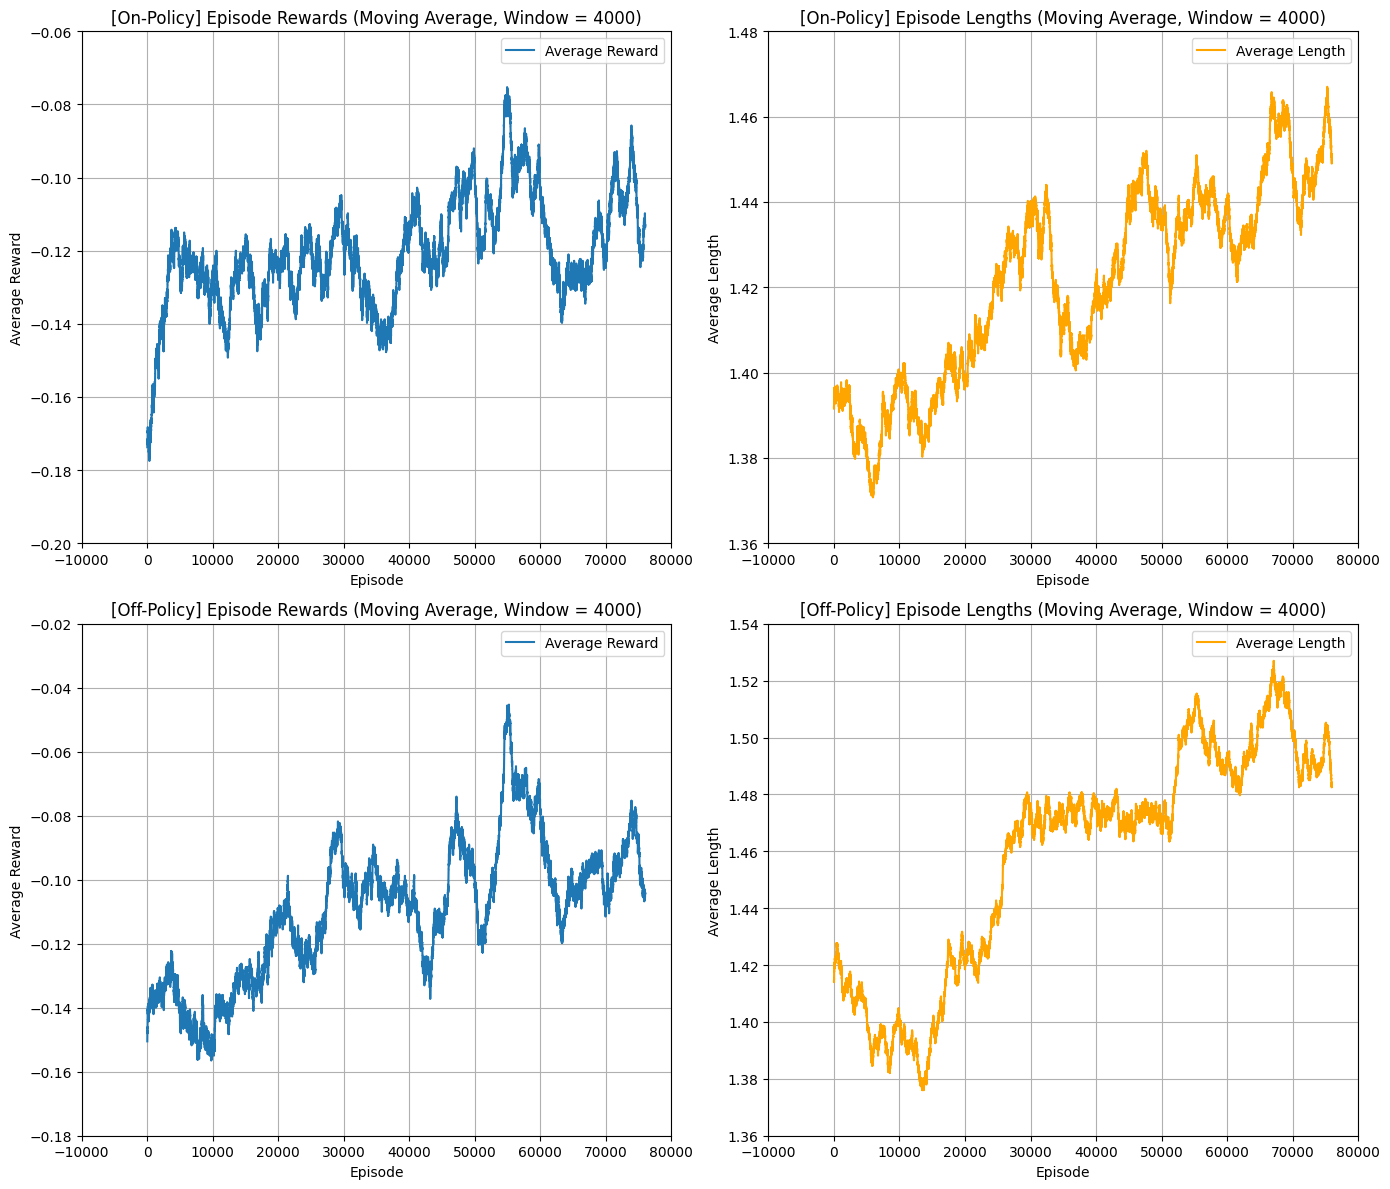

In [16]:
compare_plots(
    plot_rewards,
    agents_data=[(episode_returns_on, episode_lengths_on), (episode_returns_off, episode_lengths_off)],
    agent_names=["On-Policy", "Off-Policy"],
    window=4000  # kwargs opcionales
)

**On‑Policy**: Recompensa media y duración media

---

- Al principio, la recompensa media parte muy negativa (~‑0.18). Esto se debe a que el agente aún no ha aprendido qué decisiones resultan en mejores retornos en Blackjack. Con pocas experiencias, las actualizaciones de valor están basadas en trayectorias poco representativas.
- En los **primeros 10 000 episodios** se aprecia una subida sostenida. Esto refleja que, conforme el agente acumula experiencias siguiendo *su propia política*, aprende qué acciones y secuencias evitan resultados negativos o conducen a tablas/ganancias. En métodos on‑policy, la política se actualiza únicamente con la experiencia obtenida siguiendo esa misma política, por lo que la mejora es gradual y a veces errática.
- Los **picos** en la gráfica representan momentos en los que, por azar y exploración limitada, se generan episodios con retornos menos negativos o empates/ganancias más frecuentes. Estos picos indican momentos de exploración donde el agente encuentra trayectorias de alto retorno debido a una exploración oportuna dentro de su política.
- Los **valles** se deben a fases temporales donde la política actual conduce a decisiones subóptimas, por ejemplo pidiendo carta cuando la situación favorece plantarse. Estos valles indican que la política no está aprendiendo de manera eficiente y lleva al agente a hacer elecciones pobres.
- En el libro de referencia de Sutton Barto, capítulo 5, se explica este problema y se expone que Monte Carlo tiene una *alta varianza* en las actualizaciones porque los retornos dependen de trayectorias completas. Eso explica las oscilaciones de la recompensa media.
- La **duración media de episodios tiende a aumentar** con el tiempo. Esto indica que, a medida que la política mejora, el agente evita terminar rápidamente (por bustear o plantarse de forma prematura) y toma decisiones más equilibradas entre pedir y plantarse, extendiendo el número de pasos hasta llegar al resultado final. Esto también refleja que el agente está aprendiendo a manejar mejor la incertidumbre y las decisiones difíciles, lo que resulta en episodios más largos.

**Off‑Policy**: Recompensa media y duración media

---

- La recompensa media en off‑policy también inicia negativa (~‑0.15) y muestra una tendencia de mejora hacia valores menos negativos, pero con **menor amplitud en picos y valles** que on‑policy. Esto ocurre porque off‑policy puede generar experiencias con una política de comportamiento distinta (mayor exploración) que cubre mejor el espacio de estados/acciones, haciendo que los promedios sean más estables.
- Los **picos en la curva off‑policy** representan momentos en los que las experiencias de alto retorno son más frecuentes debido a que la política de comportamiento explora decisiones que no seguiría estrictamente la política objetivo. Estos picos en off‑policy pueden ser más suaves debido a la mayor exploración que realiza el agente.
- La **duración media en off‑policy** es mayor y más estable. La exploración más amplia permite tomar decisiones que prolongan episodios (por ejemplo, plantearse pedir una carta extra con mayor probabilidad), reflejando también una mejora indirecta en la política objetivo. Esta exploración más rica puede llevar a que los episodios duren más debido a decisiones menos arriesgadas y más cautelosas.

---

Los métodos **on-policy** y **off-policy** muestran comportamientos distintos pero complementarios. Mientras que **on-policy** presenta una mayor varianza en las recompensas y más fluctuaciones en la duración de los episodios debido a su enfoque limitado de exploración, **off-policy** ofrece un aprendizaje más estable, con una exploración más amplia que suaviza las oscilaciones y mejora la consistencia a lo largo del tiempo. A pesar de que ambos métodos mejoran gradualmente, **off-policy** tiende a converger más rápido hacia una política óptima gracias a su capacidad para explorar más situaciones y acumular experiencias diversas.


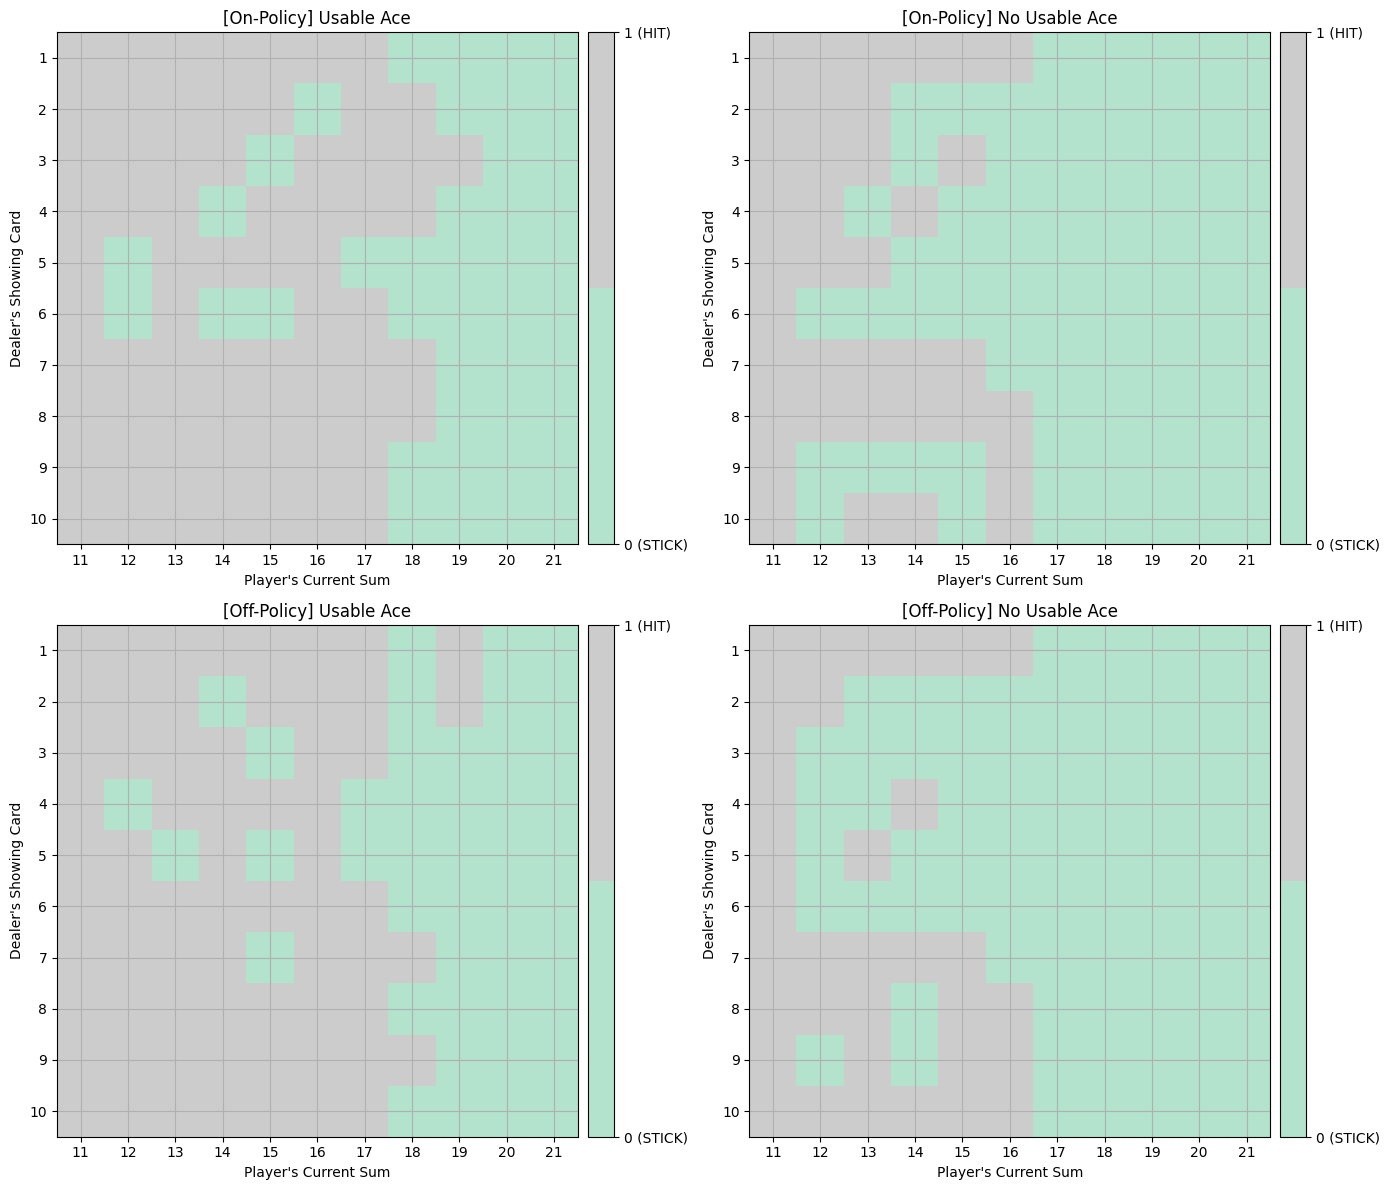

In [17]:
compare_plots(
    plot_policy,
    agents_data=[(policy_on,), (policy_off,)],
    agent_names=["On-Policy", "Off-Policy"]
)

**Ejes de la gráfica**

---

- **Eje horizontal (Player's Current Sum)**: Representa la suma de las cartas actuales del jugador, que varía entre 11 y 21. Este valor es crucial porque el jugador debe decidir si pide otra carta o se planta en función de este total. La suma es un indicador de la seguridad de la mano del jugador: valores bajos (11-16) requieren decisiones más cautelosas, mientras que valores más altos (17-21) permiten decisiones más conservadoras.
- **Eje vertical (Dealer’s Showing Card)**: Muestra la carta visible del crupier, que puede estar entre 1 y 10 (el As cuenta como 1 o 11, pero aquí se cuenta como 1). El crupier influye en las decisiones del jugador, ya que este debe anticipar la probabilidad de que el crupier termine con un total superior o inferior al 21.


On Policy

---

- As utilizable:

  - Cuando el entorno tiene carta de As como utilizable (es decir, un As que puede contar como 11 sin riesgo de exceder 21), las decisiones del agente siguen un patrón lógico: **"Hit"** (pedir carta) cuando la suma del jugador es baja (alrededor de 11-16), y **"Stick"** (plantarse) cuando la suma alcanza valores más altos (17-21). La presencia del As permite al jugador un **margen de maniobra**, ya que el riesgo de exceder 21 es reducido, lo que justifica la decisión de arriesgarse a pedir cartas adicionales.

- As no utilizable:

  - Cuando el entorno no incluye el As como utilizable, el agente sigue una estrategia similar, pero con **menos flexibilidad**, ya que el As no puede ser contado como 11. El agente opta por **"Hit"** cuando la suma es baja (11-14) y **"Stick"** más rápido, a partir de 15, en comparación con el caso anterior donde el "As utilizable" da más margen. Esta menor flexibilidad refleja la necesidad de ser más conservador en las decisiones cuando las cartas disponibles no ofrecen tanto margen de maniobra. En situaciones de "As no utilizable", el riesgo de sobrepasar 21 es mayor, lo que hace que el agente sea más conservador al momento de decidir si pedir o no otra carta.

Off Policy

---

- As utilizable:

  - En el caso **off-policy**, el agente sigue una estrategia **más exploratoria**. Esto se evidencia en el mayor número de casos donde el agente sigue pidiendo carta, incluso cuando la suma del jugador es algo alta (alrededor de 16-17). Este comportamiento muestra cómo el agente, al no estar limitado a la política actual, explora más las opciones disponibles, tomando más riesgos de forma aleatoria.
  - Al estar explorando diferentes combinaciones de políticas, el agente parece tomar más riesgos de manera deliberada, y esta flexibilidad mejora la política al recopilar más información sobre diferentes situaciones.

- As no utilizable:

  - Similar al caso de **on-policy**, el agente se planta más rápidamente cuando no tiene un "As utilizable", pero la **exploración** hace que el agente pueda tomar decisiones menos estrictas, como pedir carta en algunas combinaciones de cartas, que en el caso **on-policy** resultaría en una decisión más conservadora. En este contexto, el agente off-policy, al estar explorando más combinaciones, puede encontrar mejores alternativas y seguir aprendiendo a medida que se arriesga más.
  - Esto muestra cómo el agente **off-policy** busca más activamente situaciones en las que podría haber tenido un mejor resultado, incluso si hay un riesgo de pérdida. Esta exploración activa puede conducir a una mejora más rápida de la política.

Conclusiones:

  - **On-Policy** sigue estrategias más definidas y conservadoras, que se ajustan estrictamente a la política aprendida hasta el momento. En situaciones donde el jugador tiene un "As utilizable", la decisión de pedir carta se ve claramente más extendida, mientras que con un "As no utilizable", el agente tiende a plantarse antes. Esto es coherente con la teoría de Monte Carlo, donde la política se actualiza utilizando las experiencias obtenidas en los episodios recientes.
  - **Off-Policy** muestra mayor **exploración** y una estrategia menos rígida, ya que el agente prueba más situaciones y aprende de experiencias que no necesariamente siguen la política estricta. En off-policy, el agente tiene la oportunidad de explorar diversas combinaciones de acciones, lo que le permite aprender políticas más robustas a largo plazo.
  - **Estrategias aprendidas**:
    - En **on-policy**, la política de "Hit" y "Stick" se basa directamente en la experiencia acumulada siguiendo la política actual.
    - En **off-policy**, la política tiene una mayor amplitud en su exploración de diferentes opciones, lo que puede generar mejores resultados en términos de obtener más datos de la experiencia para ajustar la política.

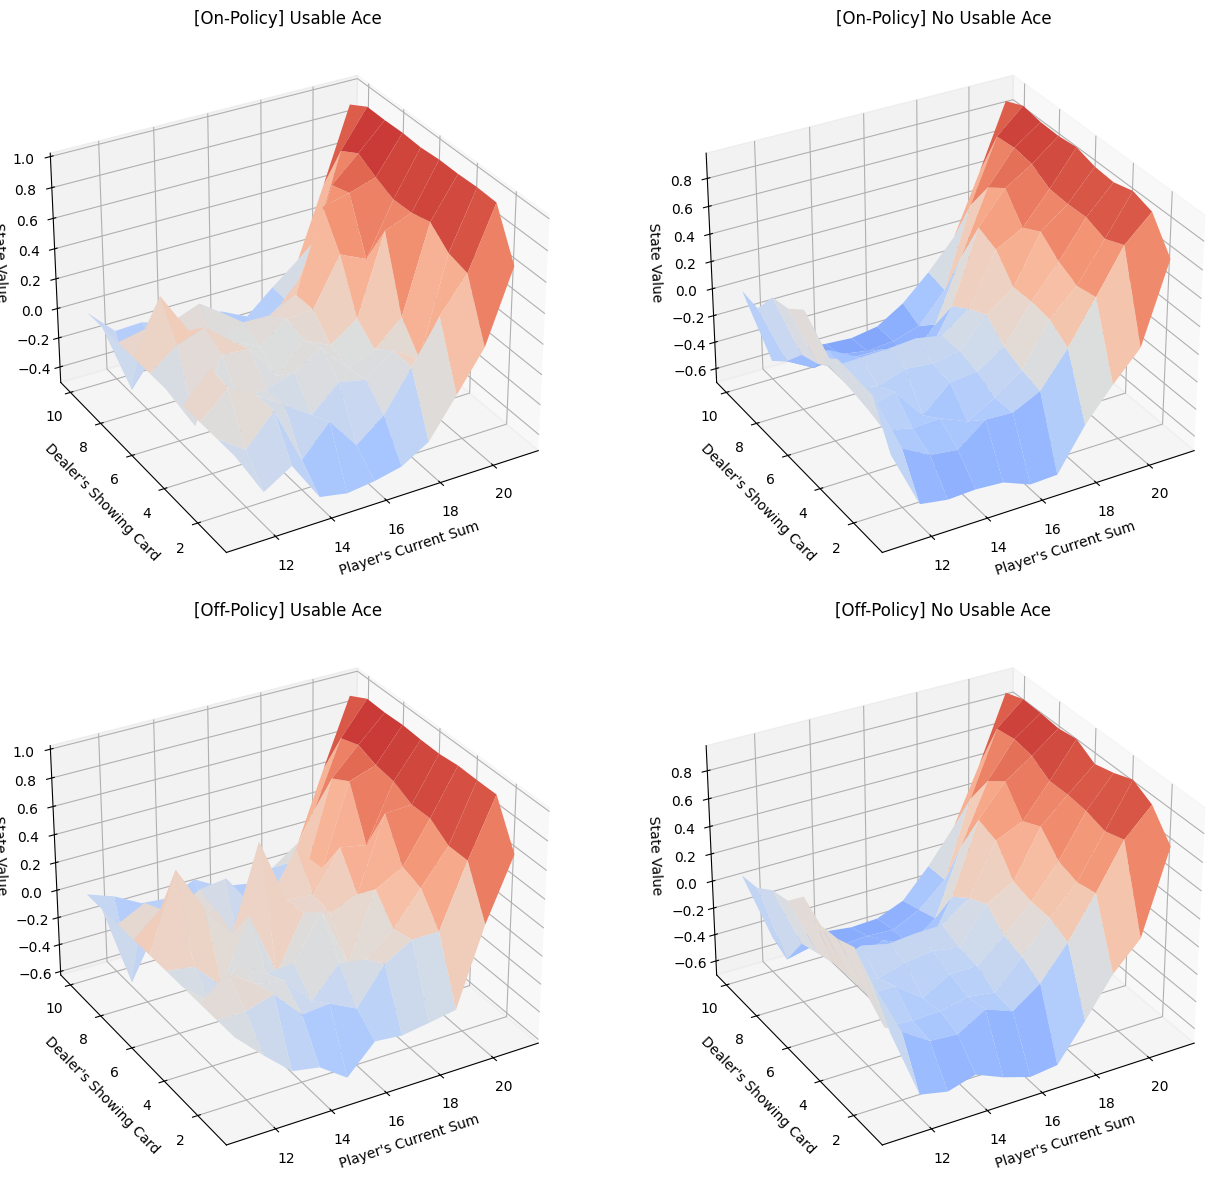

In [18]:
compare_plots(
    plot_blackjack_values,
    agents_data=[(V_on,), (V_off,)],
    agent_names=["On-Policy", "Off-Policy"]
)

**Ejes de la gráfica**

---


- **Eje horizontal (Player's Current Sum)**: Representa la suma de las cartas del jugador, que varía entre 11 y 21. Este valor es crucial ya que determina las decisiones de "Hit" (pedir carta) o "Stick" (plantarse).
- **Eje vertical (Dealer’s Showing Card)**: Representa la carta visible del crupier, que puede ser cualquier valor entre 1 y 10, con el As contando como 1 en este caso.
- **Eje Z (State Value)**: Este eje muestra el **valor estimado de estado**: el valor de estar en una combinación específica de la suma del jugador y la carta visible del crupier. Los valores más altos (rojo) indican que el estado es **más favorable**, lo que significa que el agente debería tomar la acción que maximiza las recompensas a largo plazo (por ejemplo, pidiendo más cartas o plantándose). Los valores más bajos (azul) indican que el estado es **menos favorable** y el agente debería ser más conservador, evitando tomar decisiones riesgosas.

On Policy

---

- As utilizable:

    - **Valor positivo en estados cercanos a 21**: Como se muestra en la gráfica, cuando el jugador tiene un **As utilizable**, la función de valor es alta (rojo) en situaciones donde la suma del jugador está entre **17-21**, lo que indica que es **beneficioso** pedir más cartas en situaciones en las que el jugador tiene un **As utilizable**. Esto ocurre porque un **As utilizable** reduce el riesgo de *exceder 21*, lo que le permite al jugador explorar más posibles combinaciones.
    - **Valor negativo en estados de baja suma**: En estados donde la suma del jugador es baja (por ejemplo, 11-14), el valor del estado disminuye (zonas azules), lo que sugiere que el agente debería estar más dispuesto a **pedir carta** para aumentar la probabilidad de alcanzar un total cercano a 21 sin excederlo.

- As no utilizable:

    - **Valor negativo en zonas de baja suma**: Cuando el jugador no tiene un **As utilizable**, las decisiones del agente son más conservadoras. Se observa que en la **suma baja** (11-14), el valor de la función de valor es más negativo, ya que el riesgo de exceder 21 es más alto. En estos casos, el agente opta por **plantarse** más rápidamente debido al mayor riesgo de perder.
    - **Aumento de valor a partir de la suma 17**: El valor del estado se incrementa a medida que la suma del jugador se aproxima a 17 o más, ya que el riesgo de exceder 21 es menor.

Off Policy

---

- As utilizable:

    - **Exploración activa con valores altos**: En este cuadro, el agente **off-policy** muestra una mayor exploración de opciones, con valores positivos más extendidos. Esto indica que el agente está dispuesto a **tomar más riesgos** (por ejemplo, pidiendo cartas cuando la suma del jugador es relativamente alta), lo que no ocurriría en **on-policy**. Esto refleja el comportamiento exploratorio de **off-policy**, donde el agente aprende más de las experiencias al arriesgarse a situaciones nuevas.
    - **Valor positivo extendido**: Debido a la flexibilidad en las decisiones de **off-policy**, las áreas rojas se extienden a lo largo de más combinaciones, lo que demuestra que el agente está aprendiendo más rápidamente y se adapta a situaciones nuevas con el **As utilizable**.

- As no utilizable:

    - **Exploración en condiciones subóptimas**: Similar a lo observado en el cuadro anterior, el agente **off-policy** sigue explorando más combinaciones de decisiones. Sin embargo, debido a la falta de un **As utilizable**, el riesgo de exceder 21 es más alto, lo que da lugar a valores negativos (azules) en las combinaciones con sumas más bajas.
    - **Aumento de valores cerca de la suma 17**: En valores cercanos a 17 y más, el agente **off-policy** sigue explorando diferentes combinaciones, lo que le permite aprender a adaptarse mejor a la situación.
